# Etherium Return Prediction and the Knowledge of When to Strike

## Business Question and Approach

The tasks:
    
    1.) inspect what indicators to build a percentage 5 day return model with
    
    2.) find a good preditive model
    
    3.) find a characterisation for the indicators state to find out when to buy/strike
    
    4.) evaluate 1.), 2.), and 3.) through visualizations

## Ingestion of Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, Normalizer
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor as rfr
from xgboost import XGBRegressor as xgb

In [2]:
import pandas_datareader as pdr
import datetime 

C:\Users\Aimazin\.julia\conda\3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
btci = pdr.get_data_yahoo('ETH-USD', 
                          start=datetime.datetime(2015, 5, 6), 
                          end=datetime.datetime(2020, 5, 25))


## Exploration of Data

In [4]:
btci.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1755.000000,1755.000000,1755.000000,1755.000000,1.755000e+03,1755.000000
mean,209.830156,194.263340,202.515752,202.576853,3.437265e+09,202.576853
std,243.544955,221.148728,233.330033,233.169953,5.056513e+09,233.169953
min,0.482988,0.420897,0.431589,0.434829,1.021280e+05,0.434829
25%,12.058450,11.394150,11.710750,11.718600,1.818860e+07,11.718600
50%,164.516953,153.847000,158.817001,158.434937,1.422080e+09,158.434937
75%,281.800491,263.079834,271.763519,271.731857,5.201203e+09,271.731857
max,1432.880005,1290.599976,1397.479980,1396.420044,2.808919e+10,1396.420044


In [5]:
btci.head(10)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-06,3.536610,2.521120,2.831620,2.772120,164329,2.772120
2015-08-07,2.798810,0.714725,2.793760,0.753325,674188,0.753325
2015-08-08,0.879810,0.629191,0.706136,0.701897,532170,0.701897
2015-08-09,0.729854,0.636546,0.713989,0.708448,405283,0.708448
2015-08-10,1.131410,0.663235,0.708087,1.067860,1463100,1.067860
2015-08-11,1.289940,0.883608,1.058750,1.217440,2150620,1.217440
2015-08-12,1.965070,1.171990,1.222240,1.827670,4068680,1.827670
2015-08-13,2.261880,1.754750,1.810920,1.827870,4637030,1.827870
2015-08-14,1.877240,1.570980,1.802890,1.688900,2554360,1.688900


## Creating Indicators and targets from data

In [6]:

bx = btci.iloc[:,5].values.astype(float)
tx = btci.iloc[:,1].values.astype(float)
cx = btci.iloc[:,2].values.astype(float)
bix = btci.iloc[:,4].values.astype(float)

### the indicators


In [7]:
 #create bbands indicators
btci["upperband"], btci["middleband"], btci["lowerband"] = talib.BBANDS(bx, timeperiod=8, nbdevup=2, nbdevdn=2, matype=0)

#create the SMA indicator
btci['max' + str(8)] = talib.SMA(bx,timeperiod=8) / bx

feature_names = []  # a list of the feature names for 

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [200]:
    # Create the RSI indicator
    btci['rsix' + str(n)] = talib.RSI(bx, timeperiod=n)
    
    # Create the CCI indicator
    btci['ccix' + str(n)] = talib.CCI(tx,cx,bx, timeperiod=n)
    
    # Create the MFI indicator
    btci['mfix' + str(n)] = talib.MFI(tx , cx, bx, bix, timeperiod=n)
    
   
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['max' + str(n), 'rsix' + str(n)
                                     , 'ccix' + str(n), 'mfix' + str(n)]

print(feature_names)

['max200', 'rsix200', 'ccix200', 'mfix200']


### the target

In [8]:
btci['5cum_pct']=(1+btci['Close'].pct_change(5)).cumprod()


In [9]:
btci.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1755 entries, 2015-08-06 to 2020-05-26
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   High        1755 non-null   float64
 1   Low         1755 non-null   float64
 2   Open        1755 non-null   float64
 3   Close       1755 non-null   float64
 4   Volume      1755 non-null   int64  
 5   Adj Close   1755 non-null   float64
 6   upperband   1748 non-null   float64
 7   middleband  1748 non-null   float64
 8   lowerband   1748 non-null   float64
 9   max8        1748 non-null   float64
 10  rsix200     1555 non-null   float64
 11  ccix200     1556 non-null   float64
 12  mfix200     1555 non-null   float64
 13  5cum_pct    1750 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 205.7 KB


## Evaluating indicators with target

In [10]:
corr = btci.corr()


<function matplotlib.pyplot.show(*args, **kw)>

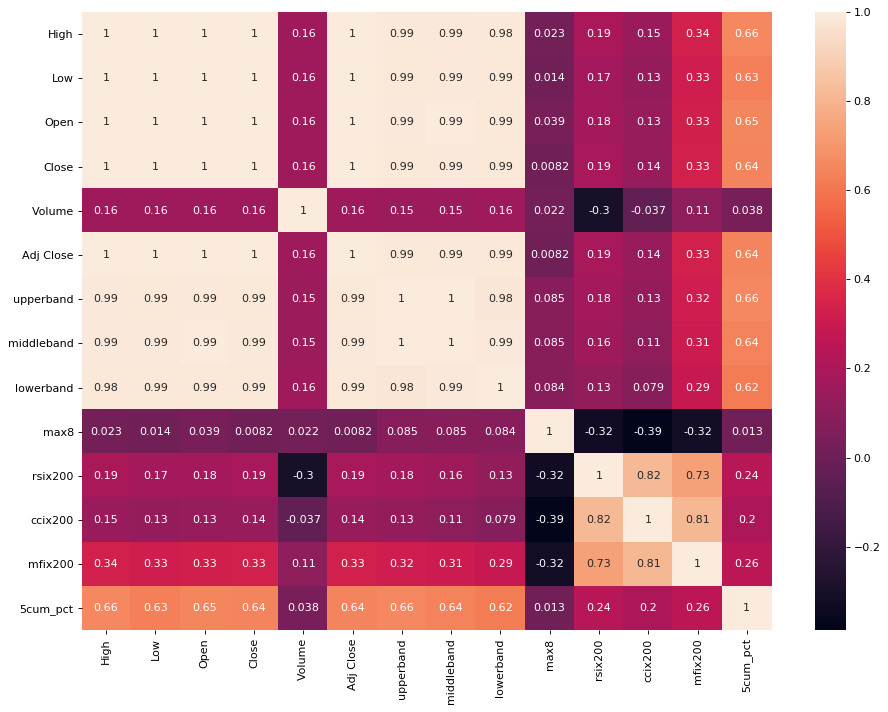

In [11]:

plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show  # show the plot

## Building and none visual evaluations of models

### train test split of series data

In [12]:

con=btci.shape[0]
con60=con-60

X_train = scale(btci.iloc[201:con60,6:13].values)
X_test = scale(btci.iloc[(con60-1):con,6:13].values)

y_train = btci.iloc[201:con60,-1].values
y_test = btci.iloc[(con60-1):con,-1].values

### Linear model

In [13]:
lm_model = LinearRegression()

In [14]:
lm_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
pred = lm_model.predict(X_test)

In [16]:
print(lm_model.score(X_train,y_train))

0.4804645073154664


In [17]:
print(lm_model.score(X_test,y_test))

-3218959.638548151


### SVM model

In [18]:
sv_model = SVR(kernel='linear')

In [19]:
sv_model.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [20]:
predsv = sv_model.predict(X_test)

In [21]:
print(sv_model.score(X_test,y_test))

-0.1925366344726196


### KNN model

In [22]:
kn_model = KNeighborsRegressor(n_neighbors=7)

In [23]:
kn_model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

In [24]:
predkn = kn_model.predict(X_test)

In [25]:
predkntr = kn_model.predict(X_train)

In [26]:
print(kn_model.score(X_test,y_test))

-6927.031412220253


### RandomForest model

In [27]:
R=rfr()
R.fit(X_test,y_test)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [28]:
print(R.score(X_test,y_test))

0.9982651472063894


In [29]:
predr=R.predict(X_test)

### XGBoost model

In [30]:
X=xgb()
X.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
predx=X.predict(X_test)

In [32]:
print(X.score(X_test,y_test))

-14455.11148935683


#### the randomforest model is th most supirior

## Building representations for each state in time

#### we do this by clustering the indicators in 5 theoretical states:
    -- mono
    -- up
    -- up steep
    -- down
    -- down steep

In [33]:
from sklearn.cluster import KMeans

In [34]:
kmeans = KMeans(n_clusters=5) # You want cluster the passenger records into 2: Survived or Not survived
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [35]:
predclutr=kmeans.predict(X_train)

In [36]:
predclu=kmeans.predict(X_test)

## Visual Evaluation

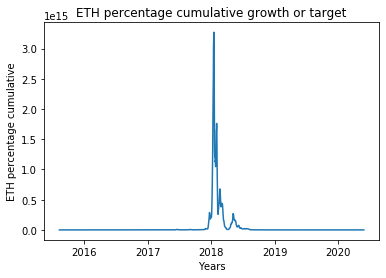

In [37]:
plt.plot(btci['5cum_pct'].dropna())
plt.title('ETH percentage cumulative growth or target')
plt.xlabel('Years')
plt.ylabel('ETH percentage cumulative')
plt.show()

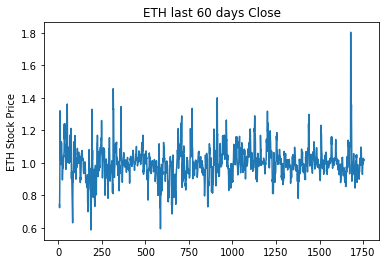

In [38]:
plt.plot(btci.iloc[:,9].values)
plt.title('ETH last 60 days Close')
plt.ylabel('ETH Stock Price')
plt.show()

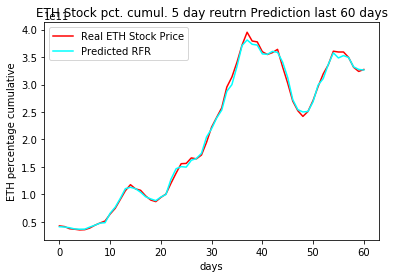

In [39]:
# Visualising the results

plt.plot(y_test-8919, color = 'red', label = 'Real ETH Stock Price')
#plt.plot(predx, color = 'blue', label = 'Predicted XGB')
#plt.plot(predkn, color = 'green', label = 'Predicted KNN')
plt.plot(predr-8919, color = 'cyan', label = 'Predicted RFR')
plt.title('ETH Stock pct. cumul. 5 day reutrn Prediction last 60 days')
plt.xlabel('days')
plt.ylabel('ETH percentage cumulative')
plt.legend()
plt.show()

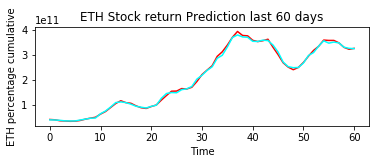

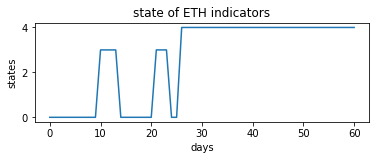

In [40]:
# Visualising the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_test-8919, color = 'red', label = 'Real ETH Stock Price')
plt.plot(predr-8919, color = 'cyan', label = 'Predicted RFR')
plt.title('ETH Stock return Prediction last 60 days')
plt.xlabel('Time')
plt.ylabel('ETH percentage cumulative')
plt.show()
plt.subplot(2,1,2)
plt.plot(predclu)
plt.title('state of ETH indicators')
plt.xlabel('days')
plt.ylabel('states')
plt.show()

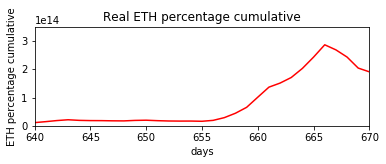

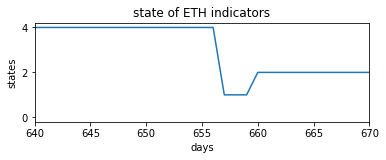

In [41]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_train-8919, color = 'red', label = 'Real ETH percentage cumulative')
plt.title('Real ETH percentage cumulative')
plt.xlabel('days')
plt.ylabel('ETH percentage cumulative')
plt.ylim(0,350000000000000)
plt.xlim(640,670)
plt.show()

plt.subplot(2,1,2)
plt.plot(predclutr)
plt.title('state of ETH indicators')
plt.xlim(640,670)
plt.xlabel('days')
plt.ylabel('states')
plt.show()

#### what we can see from these graphs is how the randomforest model did on unknown data, and that the state representations captured the rising trend or when to strike in "percentage cumulative product over 5 days" although due the randomness of picking specific states. all in all one can call this whole exercise a success answering all our questions.